In [1]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# General imports
from fastai.imports import *
# Data augmentation (transformations)
from fastai.transforms import * 
# Convolutional learner class
from fastai.conv_learner import *
# Model architecture
from fastai.model import *
# Dataset handling class
from fastai.dataset import *
# SGD with restarts
from fastai.sgdr import *
# Plotting
from fastai.plots import *

# Check GPU hardware is available
print(f'Cuda available: {torch.cuda.is_available()}')
print(f'Cudnn enabled:  {torch.backends.cudnn.enabled}')

PATH = "/home/paperspace/data/dogscats/"

# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

sz = 224
arch = resnet34

Cuda available: True
Cudnn enabled:  True


In [2]:
tfms = tfms_from_model(f_model=arch, sz=sz) # this is has no transformation
data = ImageClassifierData.from_paths(path=PATH, tfms=tfms)
learn = ConvLearner.pretrained(f=arch, data=data, precompute=True)

---

In [98]:
def rand_by_mask(mask):
    """
    `mask` is a bool array of correct or incorrect predictions.
    called by rand_by_correct()

    `np.where(mask)[0]` this is an array of indicies

    returns an array of image IDs given a boolean array
    eg: array([562, 83, 762, 786])"""
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
# mask is a boolean matrix

def rand_by_correct(is_correct):
    """returns an array of image IDs"""
    return rand_by_mask((preds == data.val_y)==is_correct)


def most_by_mask(mask, mult):
    """called by most_by_correct
    returns an array of image IDs given a boolean matrix"""
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    """returns an array of image IDs"""
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


def load_img_id(ds, idx):
    """called by plot_val_with_title
    load a pic & return it as a np.array"""
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    """called by plot_val_with_title
    create a subplot of pics"""
    f = plt.figure(figsize=figsize) # figsize: Width, Height in inches
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1) # add_subplot(nrows, ncols, index)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def plot_val_with_title(idxs, title):
    """take a list of image indicies and plot them on a row"""
    imgs = [load_img_id(data.val_ds,x) for x in idxs]# a list of images
    title_probs = [probs[x] for x in idxs]# a list probabilities
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')


In [4]:
log_preds = np.load('log_preds.npy', allow_pickle=False)

### How are they used?

#### `rand_by_correct`

Correctly classified


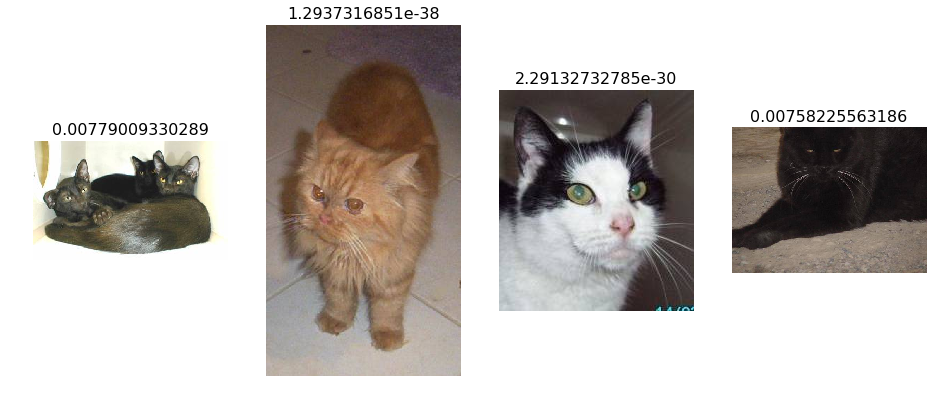

In [12]:
# a few correct labels at random
plot_val_with_title(rand_by_correct(is_correct=True), title="Correctly classified")

# prints a row of 4 pics, with title (probability of each img)

```python
def rand_by_mask(mask):
    """called by rand_by_correct()
    returns an array of image IDs given a boolean matrix"""
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
# mask is a boolean matrix
# mask == (preds == data.val_y)==is_correct
# is_correct is either True or False

def rand_by_correct(is_correct):
    """returns an array of image IDs"""
    return rand_by_mask((preds == data.val_y)==is_correct)
```


    plot_val_with_title() calls
        rand_by_correct() calls           | returns a (4,) array
            rand_by_mask() calls          | returns a (4,) array
                np.random.choice() calls  | returns a (4,) array
                    np.where()            | returns a (1985,) array

        load_img_id()
        plots()



---

### Explain: 
```python
preds = np.argmax(log_preds, axis=1)
```

In [58]:
# log_preds: log predictions. for cats & dogs
log_preds[:10]

array([[ -0.00007,  -9.50484],
       [ -0.004  ,  -5.52349],
       [ -0.00096,  -6.95104],
       [ -0.00013,  -8.92157],
       [ -0.00006,  -9.67566],
       [ -0.00045,  -7.70662],
       [ -0.00006,  -9.68205],
       [ -0.00004, -10.10989],
       [ -0.0007 ,  -7.26772],
       [ -0.00011,  -9.13099]], dtype=float32)

In [93]:
log_predzz = np.array(
              [[ -0.00007,  -9.50484],
               [ -0.004  ,  -5.52349],
               [ -0.00096,  -6.95104],
               [ -0.00013,  -8.92157],
               [ -0.00006,  -9.67566],
               [ -0.00045,  -7.70662],
               [ -0.00006,  -9.68205],
               [ -0.00004, -10.10989],
               [ -0.0007 ,  -7.26772],
               [ -0.00011,  -9.13099]])

In [94]:
np.argmax(log_predzz, axis=1)
# Returns the indices of the maximum values along an axis.
# axis=1 : along rows

# Returns an array of ten zeros.
# They are the INDEX of the max value at every row.
# ie, the max value of row 0 is at column 0.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
np.argmax(log_predzz, axis=0)
# axis=0 : along columns

# The result is [7, 1]
# They are the INDEX of the max value at each column.
# The max value of column 0 is at row 7.
# The max value of column 1 is at row 1.

array([7, 1])

#### What does this do: `preds = np.argmax(log_preds, axis=1)`

`np.argmax(array, axis)` finds the _indicies_ of an array along an axis.

In `log_preds`, each row has 2 columns: column 0 for the log probability of cats, and the other for dogs:

`np.argmax()` finds the max value of every row (`axis=1`), and returns its index (column index).


```
array([[ -0.00007,  -9.50484],    <-- max number is at col 0
       [ -0.004  ,  -5.52349],    <-- max number is at col 0
       [ -0.00096,  -6.95104],    <-- max number is at col 0
       [ -0.00013,  -8.92157],    <-- max number is at col 0
       [ -0.00006,  -9.67566],    <-- max number is at col 0
       [ -0.00045,  -7.70662],    <-- max number is at col 0
       [ -0.00006,  -9.68205],    <-- max number is at col 0
       [ -0.00004, -10.10989],    <-- max number is at col 0
       [ -0.0007 ,  -7.26772],    <-- max number is at col 0
       [ -0.00011,  -9.13099]]    <-- max number is at col 0
```

`np.argmax(array, axis=1)` returns `[0, 0, ... 0, 0]`.

`preds` is therefore a list of what the model's predictions in categorical terms.


---
Whereas if we set `axis=0`, we'd be looking at it column-wise:

```
        max number is at row7
              |      max number is at row1
              |         |
              V         V
array([[ -0.00007,  -9.50484],
       [ -0.004  ,  -5.52349],
       [ -0.00096,  -6.95104],
       [ -0.00013,  -8.92157],
       [ -0.00006,  -9.67566],
       [ -0.00045,  -7.70662],
       [ -0.00006,  -9.68205],
       [ -0.00004, -10.10989],
       [ -0.0007 ,  -7.26772],
       [ -0.00011,  -9.13099]]
```

In this case, `np.argmax(array, axis=0)` returns `[7, 1]`.

In [96]:
preds.shape

(2000,)

In [97]:
preds

array([0, 0, 0, ..., 1, 1, 1])

---

### Explain:
```python
probs = np.exp(log_preds[:,1])
```

Turns log values into probabilities:

In [98]:
np.exp(log_predzz)

array([[ 0.99993,  0.00007],
       [ 0.99601,  0.00399],
       [ 0.99904,  0.00096],
       [ 0.99987,  0.00013],
       [ 0.99994,  0.00006],
       [ 0.99955,  0.00045],
       [ 0.99994,  0.00006],
       [ 0.99996,  0.00004],
       [ 0.9993 ,  0.0007 ],
       [ 0.99989,  0.00011]])

The `[:, 1]` slicing means we want all rows (`:`), but just column 1 (`, 1`) values.

In [99]:
np.exp(log_predzz[:,1])

array([ 0.00007,  0.00399,  0.00096,  0.00013,  0.00006,  0.00045,  0.00006,  0.00004,  0.0007 ,  0.00011])

---

#### what is `mask` in `np.where(mask)[0]`?

In [69]:
mask_ = (preds == data.val_y)==True
mask_ # a bool array of correct predictions

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [70]:
mask_.shape

(2000,)

In [71]:
data.val_y.shape

(2000,)

In [72]:
preds.shape

(2000,)

In [73]:
# predictions that match validation label
preds == data.val_y

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [74]:
(preds == data.val_y).shape

(2000,)

In [75]:
# predictions that are correct
(preds == data.val_y)==True

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [76]:
((preds == data.val_y)==True).shape

(2000,)

In [77]:
# predictions that are incorrect
(preds == data.val_y)==False

array([False, False, False, ..., False, False, False], dtype=bool)

In [78]:
((preds == data.val_y)==False).shape

(2000,)

Explain: `preds == data.val_y`
- Predictions that match validation dataset.

Explain: `(preds == data.val_y)==True`
- Predictions that match validation dataset. The `==True` qualifier at the end lets you pick out the correct or incorrect (`==False`) guesses.

#### `mask` is a bool list of predictions (correct or incorrect depending on a switch at the end)

#### what is the point of `a=np.where(mask)[0]`?

In [79]:
np.random.choice(a=np.where(mask_)[0], size=min(len(preds), 4), replace=False)
# Randomly choose items from an array of items
# a:       the array to draw from
# size:    how many draws
# replace: allow repeats (set to False if you want unique samples) https://stackoverflow.com/a/40689169/9762732

# numpy.random.choice(a, size=None, replace=True, p=None):
# Generates a random sample from a given 1-D array
# a : 1-D array-like or int
# size : int or tuple of ints, optional
# replace : boolean, optional

array([1980, 1268,   64, 1592])

In [80]:
# create an array for testing np.where
xx = np.arange(9.).reshape(3,3)
xx

array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.]])

In [81]:
# np.where example
np.where(xx > 5)

(array([2, 2, 2]), array([0, 1, 2]))

`np.where(condition)` returns a tuple of two arrays. the first array is the row indicies where xx>5 is true. the second array is the column indicies where xx>5 is true.

6, 7, 8 are all > 5. Their respective indicies are: (2,0), (2,1), (2,2).

If only `condition` is given, return `condition.nonzero()`. ie, the rows that are `True`.

In [82]:
np.where(mask_)[0]

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [83]:
np.nonzero(mask_)[0]
# Return the indices of the elements that are non-zero

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [84]:
mask_.shape

(2000,)

In [86]:
(np.where(mask_)[0]).shape

(1985,)

In [85]:
(np.nonzero(mask_)[0]).shape

(1985,)

#### `np.where(mask_)[0]`
Returns the indices of the elements that are non-zero. ie, gets you the row __indicies__ that are `True`.

Stores the indicies of correct guesses.

Here, we have 1,985 rows of _indicies_ that are `True` (ie, correctly predicted). We'll later use `np.random.choice` to randomly pick 4 rows from this array.

---

Practice topics:
- np.where
- np.exp
- np.argmax
- np.where
- get a filter/mask of the correctly predicted array
- get the indicies of correctly predicted rows


---

In [ ]:
# a few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
# correct cats
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

In [ ]:
# correct dogs
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [ ]:
# incorrect cats
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
# incorrect dogs
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [ ]:
# Most uncertain predictions
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

---

### Assignment

Write a function (or a combo of functions) that recreate the effect of `rand_by_mask()` and `rand_by_correct()`.

Hint: you're trying to get the row indicies that are either correct or incorrect.

Given these variables:
- `log_preds` : a (2000, 2) array of log probabilities for cats & dogs
- `data.val_y` : an (2000,) array of 1s and 0s

General steps:
1. convert `log_preds` to a categorical 1-or-0 array (2000,).
1. match the categorical predictions against the answer `data.val_y` to find the correct/incorrect predictions
1. find the indicies of correct/incorrect predictions
1. randomly pick 4 indicies
1. what if the length of predictions is less than 4?

#### Step 1

convert log_preds to a categorical 1-or-0 array

In [37]:
log_preds

array([[-0.00007, -9.50484],
       [-0.004  , -5.52349],
       [-0.00096, -6.95104],
       ..., 
       [-7.11911, -0.00081],
       [-7.55632, -0.00052],
       [-7.23719, -0.00072]], dtype=float32)

In [43]:
# Find the max value of each row, and return its column index
preds = np.argmax(log_preds, axis=1)
preds
# preds is an array of predictions in categorical label

array([0, 0, 0, ..., 1, 1, 1])

#### Step 2

match the categorical predictions against the answer data.val_y to find the correct/incorrect predictions

Make sure the `shape` of `preds` and `data.val_y` match!

In [48]:
correct_preds = (preds == data.val_y)
correct_preds

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [54]:
incorrect_preds = (preds != data.val_y)
incorrect_preds

array([False, False, False, ..., False, False, False], dtype=bool)

In [55]:
correct_preds.sum()

1985

In [56]:
incorrect_preds.sum()

15

In [ ]:
def grade(predictions, answers, is_correct: bool):
    if is_correct:
        return (predictions == answers)
    else:
        return (predictions != answers)

A succint way to find the correct/incorrect answer is to use a bool switch:

In [57]:
# this is a switch
is_correct = True

In [58]:
# correct answers
(preds == data.val_y) == is_correct

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [59]:
# incorrect answers
is_correct = False
(preds == data.val_y) == is_correct

array([False, False, False, ..., False, False, False], dtype=bool)

In [60]:
# This achieves the same goal and is more succint
def grade(predictions, answers, is_correct: bool):
    return (predictions == answers) == is_correct

#### Step 3

find the indicies of correct/incorrect predictions

In [94]:
def grade2(predictions, answers, is_correct: bool, return_indicies: bool):
    """Compare the model's predictions to the answers (labels).
    
    is_correct: if set to True, returns the correct answers. False returns incorrect answers.
    return_indicies: if True, return the row indicies of correct/incorrect answers."""
    if return_indicies:
        # return a bool array of indicies
        return np.where((predictions == answers) == is_correct)[0]
    else:
        # return a bool array
        return (predictions == answers) == is_correct

In [95]:
grade2(preds, data.val_y, is_correct=True, return_indicies=True)

array([   0,    1,    2, ..., 1997, 1998, 1999])

#### Step 4

randomly pick 4 indicies

In [108]:
def rand_by_correct2(mask):
    """"""
    return np.random.choice(mask, 4, replace=False)

In [109]:
zz = grade2(preds, data.val_y, is_correct=True, return_indicies=True)
zz

array([   0,    1,    2, ..., 1997, 1998, 1999])

#### Step 5

what if the length of predictions is less than 4?

In [110]:
zz = zz[:3]
zz

array([0, 1, 2])

In [111]:
rand_by_correct2(grade2(preds, data.val_y, is_correct=True, return_indicies=True))

array([ 100, 1384, 1949,  946])

In [112]:
# error because zz has length 3. np.random.choice was set to pick 4
rand_by_correct2(zz)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [113]:
def rand_by_correct3(mask, picks=4):
    """"""
    return np.random.choice(mask, min(len(mask), picks), replace=False)

In [117]:
rand_by_correct3(zz)

array([1, 2, 0])

Perhaps a better name is `random_preds(mask)`

In [118]:
def random_preds(mask, picks=4):
    """"""
    return np.random.choice(mask, min(len(mask), picks), replace=False)

In [120]:
random_preds(grade2(preds, data.val_y, is_correct=True, return_indicies=True), picks=2)

array([1850, 1003])

---